In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_ta as ta
import yfinance as yf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

import datetime

In [3]:
def get_data(ticker, start, end):
    data =  yf.download(ticker, progress=True, actions=True,start=start, end=end)
    data = pd.DataFrame(data)
    data.rename(columns = {'Adj Close':ticker}, inplace=True)
    data.drop(['Close', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
    data.dropna(inplace=True)
    
    return data

In [4]:
ticker =  'GOOG'

In [5]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2017, 12, 31)

stock = get_data(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


In [6]:
start_test = datetime.datetime(2018, 1, 1)
end_test = datetime.datetime(2023, 12, 31)

test_data = get_data(ticker, start_test, end_test)

[*********************100%%**********************]  1 of 1 completed


In [7]:
sc = StandardScaler(with_mean=True)

In [8]:
adx = ta.adx(stock['High'], stock['Low'], stock[ticker])
adx


,ADX_14,DMP_14,DMN_14
Date,,,
2008-01-02,NaN,NaN,NaN
2008-01-03,NaN,NaN,NaN
2008-01-04,NaN,NaN,NaN
2008-01-07,NaN,NaN,NaN
2008-01-08,NaN,NaN,NaN
...,...,...,...
2017-12-22,28.131405,26.930262,12.983713
2017-12-26,27.564489,25.585116,16.987711
2017-12-27,26.809233,24.229245,17.191492


In [9]:
stock[ticker].head(10)

Date
2008-01-02    17.065783
2008-01-03    17.069269
2008-01-04    16.363665
2008-01-07    16.170637
2008-01-08    15.733029
2008-01-09    16.269020
2008-01-10    16.107874
2008-01-11    15.896665
2008-01-14    16.284462
2008-01-15    15.881721
Name: GOOG, dtype: float64

In [10]:
stock[ticker].shift(-1).head(10)

Date
2008-01-02    17.069269
2008-01-03    16.363665
2008-01-04    16.170637
2008-01-07    15.733029
2008-01-08    16.269020
2008-01-09    16.107874
2008-01-10    15.896665
2008-01-11    16.284462
2008-01-14    15.881721
2008-01-15    15.341247
Name: GOOG, dtype: float64

In [11]:
def preprocess(data):
    for leng in [10,20,30]:
        sma = ta.sma(data[ticker], length=leng)
        data['SMA_'+f'{leng}'] = sma

    for leng in [10,20,30]:
        ema = ta.ema(data[ticker], length=leng)
        data['EMA_'+f'{leng}'] = ema

    for leng in [14, 28]:
        data['RSI_'+f'{leng}'] = ta.rsi(data[ticker], length=leng)

    stoch = ta.stoch(data['High'], data['Low'], data[ticker])
    stochk = stoch['STOCHk_14_3_3']
    data = data[13:]
    data['Stoch_Oscillator'] = stochk

    williams_r = ta.willr(data['High'], data['Low'], data[ticker])
    data['Williams_%R'] = williams_r

    adx = ta.adx(data['High'], data['Low'], data[ticker])
    data['ADX'] = adx['ADX_14']

    # data/data.shift(1) so each day is divided by previous day
    data['returns'] = np.log(data[ticker] / data[ticker].shift(1))
    data.dropna(inplace=True)
    price = data[ticker]

    data['direction'] = [1 if data.returns[i]>0 else 0 for i in range(len(data))]

    return data.dropna(axis=0)


In [12]:
stock = preprocess(stock)
test_data = preprocess(test_data)

features = ([col for col in stock.columns if col not in ['Open', 'High', 'Low', ticker, 'returns', 'Volume', 'direction']])

/tmp/ipykernel_26397/251702138.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Stoch_Oscillator'] = stochk
/tmp/ipykernel_26397/251702138.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Williams_%R'] = williams_r
/tmp/ipykernel_26397/251702138.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [13]:
stock

,Open,High,Low,GOOG,Volume,SMA_10,SMA_20,SMA_30,EMA_10,EMA_20,EMA_30,RSI_14,RSI_28,Stoch_Oscillator,Williams_%R,ADX,returns,direction
Date,,,,,,,,,,,,,,,,,,
2008-02-29,11.752698,11.948713,11.572872,11.735512,378429149,12.274766,12.547855,13.092493,12.182593,12.728847,13.332378,29.659759,29.483550,27.915204,-74.169260,37.671634,-0.008895,0
2008-03-03,11.743732,11.773869,11.210729,11.382834,303312645,12.093894,12.474530,12.973132,12.037182,12.600655,13.206601,26.745297,27.825880,22.309506,-89.202671,39.229374,-0.030513,0
2008-03-04,11.231651,11.291676,10.853817,11.073494,546910299,11.933620,12.411230,12.843908,11.861966,12.455211,13.068981,24.473686,26.472065,15.002445,-91.620735,41.119942,-0.027552,0
2008-03-05,11.089683,11.311850,11.058550,11.150704,298578968,11.780942,12.337631,12.730458,11.732646,12.330972,12.945221,26.159483,27.386518,10.166980,-88.675654,42.658665,0.006948,1
2008-03-06,11.150455,11.290182,10.739247,10.777105,299923991,11.606197,12.251690,12.634219,11.558911,12.182985,12.805343,23.433863,25.777803,7.055612,-98.536776,44.439244,-0.034079,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,53.055500,53.209999,52.972000,53.006001,15102000,52.860250,52.042750,51.831433,52.817338,52.300246,51.883564,60.716736,60.417887,82.718116,-20.363583,28.131405,-0.003305,0
2017-12-26,52.903500,53.006001,52.509998,52.837002,15212000,52.938450,52.049075,51.879216,52.820913,52.351366,51.945076,58.596013,59.399355,78.348285,-28.118878,27.564489,-0.003193,0
2017-12-27,52.869499,52.918499,52.402500,52.468498,25438000,52.982900,52.053975,51.918583,52.756838,52.362521,51.978845,54.154290,57.218156,67.773581,-48.196797,26.809233,-0.006999,0


Direction is balanced

<Axes: >

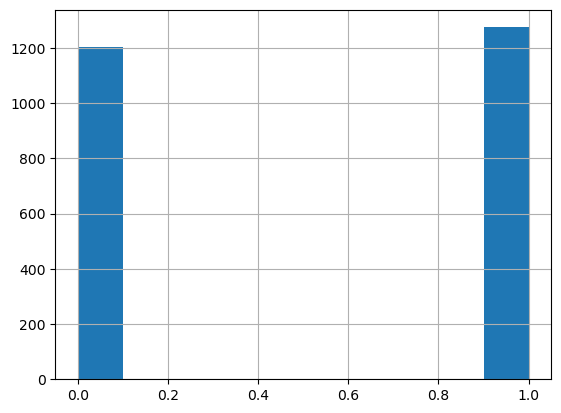

In [14]:
stock['direction'].hist()

array([[<Axes: title={'center': 'SMA_10'}>,
        <Axes: title={'center': 'SMA_20'}>,
        <Axes: title={'center': 'SMA_30'}>],
       [<Axes: title={'center': 'EMA_10'}>,
        <Axes: title={'center': 'EMA_20'}>,
        <Axes: title={'center': 'EMA_30'}>],
       [<Axes: title={'center': 'RSI_14'}>,
        <Axes: title={'center': 'RSI_28'}>,
        <Axes: title={'center': 'Stoch_Oscillator'}>],
       [<Axes: title={'center': 'Williams_%R'}>,
        <Axes: title={'center': 'ADX'}>, <Axes: >]], dtype=object)

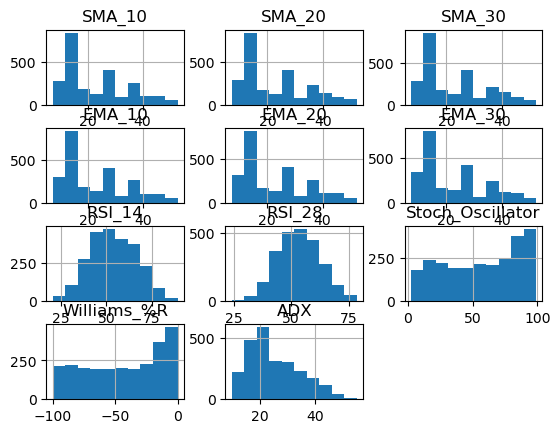

In [15]:
stock[features].hist()

In [16]:
stock[features] = sc.fit_transform(stock[features])
test_data[features] = sc.fit_transform(test_data[features])

x = stock[features]
y = stock['direction']

In [17]:
feature_selector = linear_model.LogisticRegression()

efs = EFS(estimator=feature_selector, 
          min_features=1,
          max_features=10,
          scoring='accuracy',
          cv=5).fit(x, y)

print('Best features:', efs.best_feature_names_)
features = list(efs.best_feature_names_)

x = stock[features]

Features: 2046/2046

Best features: ('RSI_28', 'Stoch_Oscillator', 'Williams_%R')


In [18]:
stock[features].corr()

,RSI_28,Stoch_Oscillator,Williams_%R
RSI_28,1.000000,0.704717,0.678945
Stoch_Oscillator,0.704717,1.000000,0.920415
Williams_%R,0.678945,0.920415,1.000000


In [19]:
param_selector = linear_model.LogisticRegression()
param_grid = [    
    {'penalty' : ['l1', 'l2', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    }
]
model_selector = GridSearchCV(param_selector, param_grid = param_grid, cv = 5, n_jobs=-1)
model_selector.fit(x,y)
model = model_selector.best_estimator_

/home/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2

In [20]:
model.get_params()

{'C': 0.23357214690901212,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [21]:
def predict(data, model):  
        data['y_pred'] = model.predict(data[features]) 

predict(test_data, model)

In [22]:
target_names = ['direction_up', 'direction_down']

def measure_classification():
    y_true = test_data['direction']
    y_pred = test_data['y_pred']
    print(f'====== {model} Classification report ======')
    print(classification_report(y_true, y_pred, target_names=target_names))
    print("roc-auc score: ", roc_auc_score(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[1, 0]))


In [23]:
measure_classification()

====== LogisticRegression(C=0.23357214690901212, penalty='l1', solver='saga') Classification report ======
                precision    recall  f1-score   support

  direction_up       0.82      0.83      0.83       686
direction_down       0.85      0.85      0.85       783

      accuracy                           0.84      1469
     macro avg       0.84      0.84      0.84      1469
  weighted avg       0.84      0.84      0.84      1469

roc-auc score:  0.8359983840279406
[[662 121]
 [119 567]]


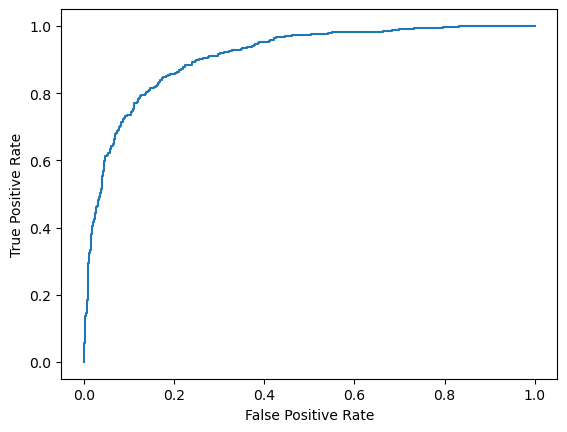

In [24]:
y_true = test_data['direction']
y_pred_proba = model.predict_proba(test_data[features])[::,1]

fpr, tpr, threshold = roc_curve(y_true,  y_pred_proba)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Conclusion: good results because using todays data to predict if price will increase or decrease by the end of the day. Impractical as would need really good estimate of closing price to predict this correctly.

In [25]:
def get_roc_curve(y_pred):
    y_true = [0,0,1,1,1,0,1,0]
    fpr, tpr, _ = roc_curve(y_true,  y_pred)
    return pd.DataFrame({"fpr":fpr, "tpr":tpr})

Perfect and Random Classifiers ROC curves

/tmp/ipykernel_26397/315550759.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


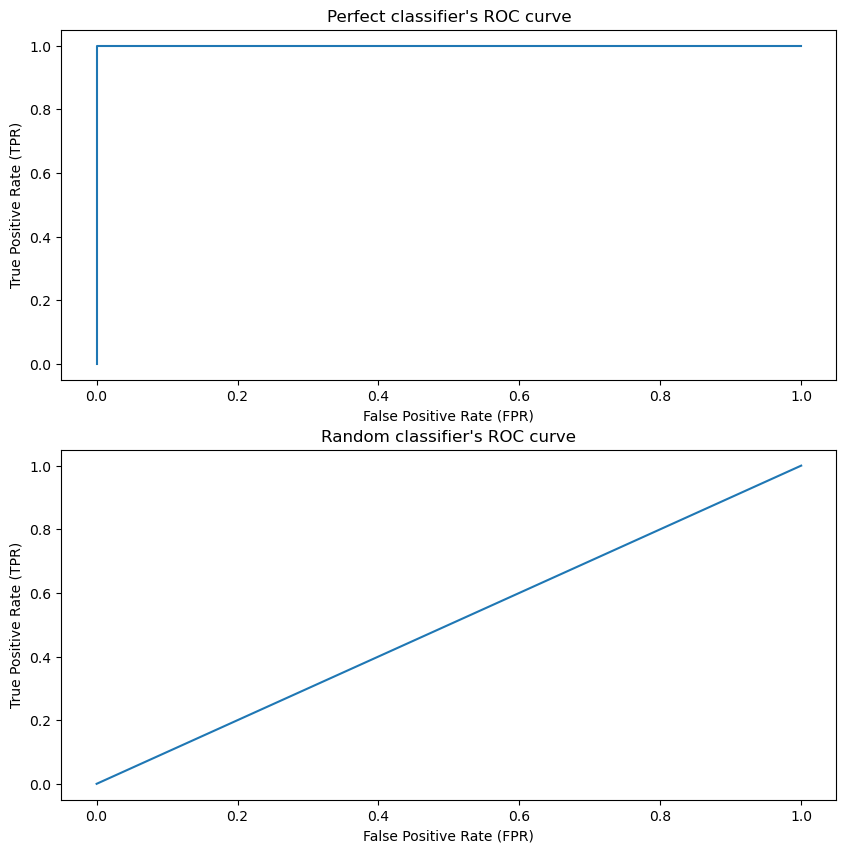

In [26]:
data_perf = get_roc_curve([0,0,1,1,1,0,1,0])
data_rand = get_roc_curve([1,1,1,1,1,1,1,1])


fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(10)

axes[0].plot(data_perf["fpr"], data_perf["tpr"])
axes[0].set_title("Perfect classifier's ROC curve")
axes[0].set_xlabel('False Positive Rate (FPR)')
axes[0].set_ylabel('True Positive Rate (TPR)')


axes[1].plot(data_rand["fpr"], data_rand["tpr"])
axes[1].set_title("Random classifier's ROC curve")
axes[1].set_xlabel('False Positive Rate (FPR)')
axes[1].set_ylabel('True Positive Rate (TPR)')


fig.show()
